In [1]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import IPython.display

import operator

In [2]:
def showimage(cimg):
    if len(cimg.shape) == 2:
        img = Image.fromarray(cimg)
    else:
        img = Image.fromarray(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
    b = BytesIO()
    img.save(b, format='png')

    IPython.display.display(IPython.display.Image(data=b.getvalue(), format='png', embed=True))

In [3]:
MIN_CONTOUR_AREA = 100

RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

In [4]:
# Read training classifications and images

npaClassifications = np.loadtxt("classifications.txt", np.float32)
npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)

npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))

# Initialize and read the classifications into KNN
kNearest = cv2.ml.KNearest_create()
kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)

True

In [5]:
class ContourWithData():
    def __init__(self, contour):
        self.npaContour = contour
        self.boundingRect = cv2.boundingRect(contour)
        self.rectX, self.rectY, self.rectWidth, self.rectHeight = self.boundingRect 
        self.area = cv2.contourArea(contour)

    def isValid(self):  
        # this is oversimplified, for a production grade program
        # much better validity checking would be necessary
        return self.area >= MIN_CONTOUR_AREA

In [13]:
imgTestingNumbers = cv2.imread("test1.png")
#imgTestingNumbers = cv2.imread("../ramq.jpg")

imgGray = cv2.cvtColor(imgTestingNumbers, cv2.COLOR_BGR2GRAY)
imgBlurred = cv2.GaussianBlur(imgGray, (5,5), 0)

# Same threshold parameters as the training
imgThresh = cv2.adaptiveThreshold(imgBlurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

imgContours, npaContours, npaHierarchy = cv2.findContours(imgThresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Wrap all of the contours in helper class
allContoursWithData = [ContourWithData(contour) for contour in npaContours]

# Get the list of "valid" contours and return them sorted by X coordinate
validContoursWithData = sorted((contour for contour in allContoursWithData if contour.isValid()), 
                                key=operator.attrgetter("rectX"))

# declare final string, this will have the final number sequence by the end of the program
finalString = []

for contourWithData in validContoursWithData:
    # draw a green rect around the current char
    cv2.rectangle(imgTestingNumbers,
                  (contourWithData.rectX, contourWithData.rectY),
                  (contourWithData.rectX + contourWithData.rectWidth, 
                   contourWithData.rectY + contourWithData.rectHeight),      # lower right corner
                  (0, 255, 0),              # green
                  2)                        # thickness

    # crop char out of threshold image
    imgROI = imgThresh[contourWithData.rectY : contourWithData.rectY + contourWithData.rectHeight,
                       contourWithData.rectX : contourWithData.rectX + contourWithData.rectWidth]
        
    # resize image, this will be more consistent for recognition and storage
    imgROIResized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
    # flatten image into 1d numpy array
    npaROIResized = imgROIResized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))      
    # convert from 1d numpy array of ints to 1d numpy array of floats
    npaROIResized = np.float32(npaROIResized)       
    #  call KNN function find_nearest
    retval, npaResults, neigh_resp, dists = kNearest.findNearest(npaROIResized, k = 1)
    # get character from results (float -> int -> chr)
    strCurrentChar = chr(int(npaResults[0][0]))
    
    # append current char to full string
    finalString.append(strCurrentChar)
    
    # Useful debug of the output, nice to see what it's matching
    showimage(imgROI)
    print "GOT: ", strCurrentChar

    
print "\n" + ''.join(finalString) + "\n"                  # show the full string


GOT:  A


GOT:  B


GOT:  C


GOT:  1


GOT:  2


GOT:  3

ABC123



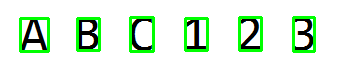

In [47]:
showimage(imgTestingNumbers)